In [1]:
from IPython.display import Image
import os
os.environ['http_proxy'] = 'http://127.0.0.1:7890'
os.environ['https_proxy'] = 'http://127.0.0.1:7890'

- Self-Supervised Contrastive Learning with SimCLR
    - Self-supervised learning, or also sometimes called unsupervised learning
    - https://arxiv.org/abs/2006.10029
- https://colab.research.google.com/github/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial17/SimCLR.ipynb#scrollTo=tyakLM-9zW5l

In [2]:
Image(url='https://github.com/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/tutorial17/simclr_contrastive_learning.png?raw=1', width=400)

In [3]:
import os
from copy import deepcopy
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
plt.set_cmap('cividis')
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0

from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export

import seaborn as sns
sns.set()

<Figure size 640x480 with 0 Axes>

In [4]:
## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

## Torchvision
import torchvision
from torchvision.datasets import STL10
from torchvision import transforms

import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

In [5]:

DATASET_PATH = "./data"
CHECKPOINT_PATH = "./pths"

NUM_WORKERS = os.cpu_count()

# Setting the seed
pl.seed_everything(42)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)
print("Number of workers:", NUM_WORKERS)

Seed set to 42


Device: cuda:0
Number of workers: 64


In [6]:
# import urllib.request
# from urllib.error import HTTPError
# # Github URL where saved models are stored for this tutorial
# base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial17/"
# # Files to download
# pretrained_files = ["SimCLR.ckpt", "ResNet.ckpt",
#                     "tensorboards/SimCLR/events.out.tfevents.SimCLR",
#                     "tensorboards/classification/ResNet/events.out.tfevents.ResNet"]
# pretrained_files += [f"LogisticRegression_{size}.ckpt" for size in [10, 20, 50, 100, 200, 500]]
# os.makedirs(CHECKPOINT_PATH, exist_ok=True)
# # For each file, check whether it already exists. If not, try downloading it.
# for file_name in pretrained_files:
#     file_path = os.path.join(CHECKPOINT_PATH, file_name)
#     if "/" in file_name:
#         os.makedirs(file_path.rsplit("/",1)[0], exist_ok=True)
#     if not os.path.isfile(file_path):
#         file_url = base_url + file_name
#         print(f"Downloading {file_url}...")
#         try:
#             urllib.request.urlretrieve(file_url, file_path)
#         except HTTPError as e:
#             print("Something went wrong. Please try to download the file from the GDrive folder, or contact the author with the full output including the following error:\n", e)

### SimCLR

#### Data Augmentation for Contrastive Learning

In [7]:
class ContrastiveTransformations(object):
    
    def __init__(self, base_transforms, n_views=2):
        self.base_transforms = base_transforms
        self.n_views = n_views
        
    def __call__(self, x):
        return [self.base_transforms(x) for i in range(self.n_views)]

In [8]:
contrast_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
                                          transforms.RandomResizedCrop(size=96),
                                          transforms.RandomApply([
                                              transforms.ColorJitter(brightness=0.5, 
                                                                     contrast=0.5, 
                                                                     saturation=0.5, 
                                                                     hue=0.1)
                                          ], p=0.8),
                                          transforms.RandomGrayscale(p=0.2),
                                          transforms.GaussianBlur(kernel_size=9),
                                          transforms.ToTensor(),
                                          transforms.Normalize((0.5,), (0.5,))
                                         ])

In [9]:
unlabeled_data = STL10(root=DATASET_PATH, split='unlabeled', download=True, 
                       transform=ContrastiveTransformations(contrast_transforms, n_views=2))
train_data_contrast = STL10(root=DATASET_PATH, split='train', download=True, 
                            transform=ContrastiveTransformations(contrast_transforms, n_views=2))

Files already downloaded and verified
Files already downloaded and verified


Seed set to 42


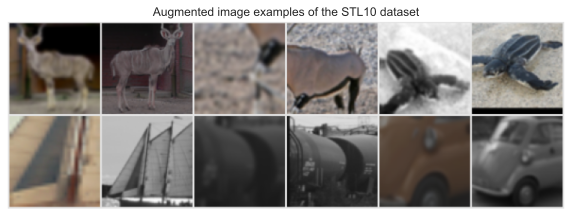

In [10]:
# Visualize some examples
pl.seed_everything(42)
NUM_IMAGES = 6
imgs = torch.stack([img for idx in range(NUM_IMAGES) for img in unlabeled_data[idx][0]], dim=0)
img_grid = torchvision.utils.make_grid(imgs, nrow=6, normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(10,5))
plt.title('Augmented image examples of the STL10 dataset')
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()

### SimCLR implementation

$$
\ell_{i,j}=-\log \frac{\exp(\text{sim}(z_i,z_j)/\tau)}{\sum_{k=1}^{2N}\mathbb{1}_{[k\neq i]}\exp(\text{sim}(z_i,z_k)/\tau)}=-\text{sim}(z_i,z_j)/\tau+\log\left[\sum_{k=1}^{2N}\mathbb{1}_{[k\neq i]}\exp(\text{sim}(z_i,z_k)/\tau)\right]
$$


$$
\text{sim}(z_i,z_j) = \frac{z_i^\top \cdot z_j}{||z_i||\cdot||z_j||}
$$

- 每次迭代中，对于每张图像 $x$ 会生成两种不同的数据增强版本，我们分别称为 $\tilde{x}_i$ 和 $\tilde x_j$，这两种增强图像都会被编码为一维特征向量，我们希望最大化它们之间的相似性，同时最小化它与批次中其他图像的相似性。
- 基础编码器 $f(\cdot)$，这里用 resnet-18，输出表示为 $f(\tilde x_i)=h_i$
- project head $g(\cdot)$ 将表示向量 $h$ 映射到对比损失计算的空间，通常为一个带有非线性的简单 MLP。
    - 我们遵循原始 SimCLR 论文设置，将其定义为两层带 ReLU 激活的 MLP。
    - 在后续论文 SimCLRv2 中，作者提到更大的 MLP 隐藏层可以显著提升性能，因此我们在实验中将隐藏层维度扩大了 4 倍。不过更深的 MLP 容易导致在给定数据集上的过拟合。

In [11]:
class SimCLR(pl.LightningModule):
    
    def __init__(self, hidden_dim, lr, temperature, weight_decay, max_epochs=500):
        super().__init__()
        self.save_hyperparameters()
        assert self.hparams.temperature > 0.0, 'The temperature must be a positive float!'
        # Base model f(.)
        self.convnet = torchvision.models.resnet18(num_classes=4*hidden_dim)  # Output of last linear layer
        # The MLP for g(.) consists of Linear->ReLU->Linear 
        self.convnet.fc = nn.Sequential(
            self.convnet.fc,  # Linear(ResNet output, 4*hidden_dim)
            nn.ReLU(inplace=True),
            nn.Linear(4*hidden_dim, hidden_dim)
        )

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), 
                                lr=self.hparams.lr, 
                                weight_decay=self.hparams.weight_decay)
        lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer,
                                                            T_max=self.hparams.max_epochs,
                                                            eta_min=self.hparams.lr/50)
        return [optimizer], [lr_scheduler]
        
    def info_nce_loss(self, batch, mode='train'):
        imgs, _ = batch
        imgs = torch.cat(imgs, dim=0)
        
        # Encode all images
        feats = self.convnet(imgs)
        # Calculate cosine similarity
        cos_sim = F.cosine_similarity(feats[:,None,:], feats[None,:,:], dim=-1)
        # Mask out cosine similarity to itself
        self_mask = torch.eye(cos_sim.shape[0], dtype=torch.bool, device=cos_sim.device)
        cos_sim.masked_fill_(self_mask, -9e15)
        # Find positive example -> batch_size//2 away from the original example
        pos_mask = self_mask.roll(shifts=cos_sim.shape[0]//2, dims=0)
        # InfoNCE loss
        cos_sim = cos_sim / self.hparams.temperature
        nll = -cos_sim[pos_mask] + torch.logsumexp(cos_sim, dim=-1)
        nll = nll.mean()
        
        # Logging loss
        self.log(mode+'_loss', nll)
        # Get ranking position of positive example
        comb_sim = torch.cat([cos_sim[pos_mask][:,None],  # First position positive example
                              cos_sim.masked_fill(pos_mask, -9e15)], 
                             dim=-1)
        sim_argsort = comb_sim.argsort(dim=-1, descending=True).argmin(dim=-1)
        # Logging ranking metrics
        self.log(mode+'_acc_top1', (sim_argsort == 0).float().mean())
        self.log(mode+'_acc_top5', (sim_argsort < 5).float().mean())
        self.log(mode+'_acc_mean_pos', 1+sim_argsort.float().mean())
        
        return nll
        
    def training_step(self, batch, batch_idx):
        return self.info_nce_loss(batch, mode='train')
        
    def validation_step(self, batch, batch_idx):
        self.info_nce_loss(batch, mode='val')

#### Training

In [12]:
def train_simclr(batch_size, max_epochs=500, **kwargs):
    # Add print statements for debugging
    print("Starting SimCLR training...")
    
    tb_logger = pl.loggers.TensorBoardLogger(save_dir=os.path.join(CHECKPOINT_PATH, 'logs'),
                                            name='SimCLR',
                                            default_hp_metric=False)
    
    trainer = pl.Trainer(default_root_dir=os.path.join(CHECKPOINT_PATH, 'SimCLR'),
                         accelerator="gpu" if str(device).startswith("cuda") else "cpu",
                         devices=1,
                         max_epochs=max_epochs,
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode='max', monitor='val_acc_top5'),
                                    LearningRateMonitor('epoch')],
                         logger=tb_logger)
    trainer.logger._default_hp_metric = None

    pretrained_filename = os.path.join(CHECKPOINT_PATH, 'SimCLR.ckpt')
    if os.path.isfile(pretrained_filename):
        print(f'Found pretrained model at {pretrained_filename}, loading...')
        model = SimCLR.load_from_checkpoint(pretrained_filename)
    else:
        print("Creating data loaders...")
        train_loader = data.DataLoader(unlabeled_data, 
                                     batch_size=batch_size,
                                     shuffle=True,
                                     drop_last=True,
                                     pin_memory=True,
                                     num_workers=min(NUM_WORKERS, 4))  # Limit workers
        val_loader = data.DataLoader(train_data_contrast,
                                   batch_size=batch_size,
                                   shuffle=False,
                                   drop_last=False,
                                   pin_memory=True,
                                   num_workers=min(NUM_WORKERS, 4))  # Limit workers
        
        print("Initializing model...")
        pl.seed_everything(42)
        model = SimCLR(max_epochs=max_epochs, **kwargs)
        
        print("Starting training...")
        trainer.fit(model, train_loader, val_loader)
        model = SimCLR.load_from_checkpoint(trainer.checkpoint_callback.best_model_path)

    return model

In [13]:
%load_ext tensorboard

In [ ]:
simclr_model = train_simclr(batch_size=512, 
                            hidden_dim=128, 
                            lr=5e-4, 
                            temperature=0.07, 
                            weight_decay=1e-4, 
                            max_epochs=300)

Starting SimCLR training...


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Seed set to 42
You are using a CUDA device ('NVIDIA GeForce RTX 4090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


Creating data loaders...
Initializing model...
Starting training...


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name    | Type   | Params | Mode 
-------------------------------------------
0 | convnet | ResNet | 11.5 M | train
-------------------------------------------
11.5 M    Trainable params
0         Non-trainable params
11.5 M    Total params
46.019    Total estimated model params size (MB)
71        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]